In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import time
import numpy.linalg as la

def plotbetapdfs(ab, sp_idx, tally):
    #ab is a 3-by-2 matrix containing the a,b parameters for the
    #priors/posteriors
    #Before the first flip: ab[0,:]=[1   1];
    #                       ab[1,:]=[.5 .5];
    #                       ab[2,:]=[50 50];

    #sp_idx is a 3-element array that specfies in which subplot to plot the
    #current distributions specified by the (a,b) pairs in ab.

    #tally is a 2-element array (# heads, # tails) containing a running count
    #of the observed number of heads and tails.
    #Before the first flip: tally=[0 0]
    num_rows = ab.shape[0]
    xs = np.arange(.001, 1, .001)

    plt.subplots_adjust(left=0, right=1, bottom=0, top=2, wspace=0.5, hspace=0.5)
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.subplot(sp_idx[0], sp_idx[1], sp_idx[2]+1)

    mark = ['-',':','--']

    for row in range(num_rows):
        a = ab[row][0]
        b = ab[row][1]
        marker = mark[row]

        vals = beta.pdf(xs, a, b)
        norm_vals = vals/np.amax(vals, axis=0)
        plt.plot(xs, norm_vals, marker)
        axes = plt.gca()
        axes.set_xlim([0, 1])
        axes.set_ylim([0, 1.2])
        plt.title('{:d} h, {:d} t'.format(*tally))
        plt.xlabel(r'Bias weighting for heads $\mu$')
        plt.ylabel(r'$p(\mu|\{data\},I)$')

[[0 0]
 [1 0]
 [2 0]
 [2 1]
 [3 1]
 [4 1]]


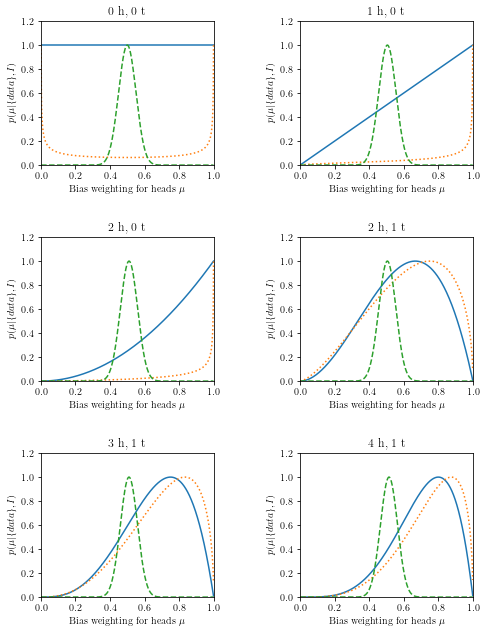

In [2]:
#prior parameters
ab = np.array([[1,1], [.5,.5], [50,50]])
#5 tosses for first case:
N = 5
tally = np.zeros((N,2), dtype = int) 
tally[0] = [0,0]
sp_idx = [3,2,0]
plotbetapdfs(ab,sp_idx,tally[0,:])

prob = [.25, .75]
for i in range(1,N):
    tally[i] = tally[i-1] + np.random.multinomial(1, prob)
x = [(tally[4] + np.random.multinomial(1, prob))]
tally = np.concatenate((tally,x))
print(tally)


for i in range(1,N+1):
    sp_idx = [3,2,i]
    ab_new = np.add(ab, [tally[i,:], tally[i,:], tally[i,:]])
    plotbetapdfs(ab_new, sp_idx, tally[i,:])

[[   0    0]
 [   1    1]
 [   1    3]
 [   1    7]
 [   2   14]
 [   7   25]
 [  15   49]
 [  27  101]
 [  63  193]
 [ 130  382]
 [ 256  768]
 [ 492 1556]]


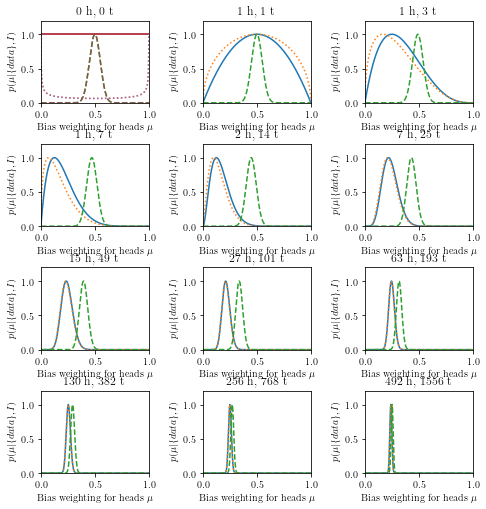

In [3]:
ab = np.array([[1,1], [.5,.5], [50,50]])
sp_idx = [5,3,0]
tally = [0,0]
plotbetapdfs(ab, sp_idx, tally)
N = 13
tally = np.zeros((N,2), dtype = int)
prob = [.25, .75]
tally[0] = [0,0]

tally[1] = tally[0] + np.random.multinomial(2, prob)
for i in range(2, N-1):
    tally[i] = tally[i-1] + np.random.multinomial(2**i - 2**(i-1), prob)
tally = tally[:N-1]
print(tally)

for i in range(0,N-1):
    sp_idx = [5,3,i]
    ab_new = np.add(ab, [tally[i,:], tally[i,:], tally[i,:]])
    plotbetapdfs(ab_new, sp_idx, tally[i,:])

In [14]:
def plotCurrent(X, Rnk, Kmus):
    N, D = X.shape
    K = Kmus.shape[0]

    InitColorMat = np.array([[1, 0, 0],
                             [0, 1, 0],
                             [0, 0, 1],
                             [0, 0, 0],
                             [1, 1, 0],
                             [1, 0, 1],
                             [0, 1, 1]])

    KColorMat = InitColorMat[0:K,:]

    colorVec = np.dot(Rnk, KColorMat)
    muColorVec = np.dot(np.eye(K), KColorMat)
    plt.scatter(X[:,0], X[:,1], c=colorVec)

    plt.scatter(Kmus[:,0], Kmus[:,1], s=200, c=muColorVec, marker='d')
    plt.axis('equal')
    plt.show()


In [21]:
def calcSqDistances(X, Kmus):
    K = Kmus.shape[0]
    N = X.shape[0]
    sqDmatrix = np.zeros((N,K), dtype = np.float32)
    for i in range(N):
        for j in range(K):
            sqDmatrix[i,j] = la.norm(X[i] - Kmus[j])
    return sqDmatrix

def determineRnk(sqDmat):
    K = sqDmat.shape[1]
    N = sqDmat.shape[0]
    Rnk = np.zeros((N,K))
    length = len(sqDmat)
    for i in range(length):
        temp = np.argmin(sqDmat[i])
        Rnk[i][temp] = 1
    return Rnk
            
def recalcMus(X, Rnk):
    N = Rnk.shape[1]
    K = X.shape[1]
    Kmus = np.zeros((N,K))
    total_sum = np.sum(Rnk, axis = 0)
    return np.divide(X.T @ Rnk, total_sum).T


def runKMeans(K,fileString):
    #load data file specified by fileString from Bishop book
    X = np.loadtxt(fileString)
    #determine and store data set information
    N = np.shape(X)[0]
    D = np.shape(X)[1]
    #allocate space for the K mu vectors
    Kmus = np.zeros((K, D))
    #initialize cluster centers by randomly picking points from the data
    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[0:K],:]
    #specify the maximum number of iterations to allow
    maxiters = 1000
    for iter in range(maxiters):
        #assign each data vector to closest mu vector as per Bishop (9.2)
        #do this by first calculating a squared distance matrix where the n,k entry
        #contains the squared distance from the nth data vector to the kth mu vector

        #sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus)

        #given the matrix of squared distances, determine the closest cluster
        #center for each data vector

        #R is the "responsibility" matrix
        #R will be an N-by-K matrix of binary values whose n,k entry is set as
        #per Bishop (9.2)
        #Specifically, the n,k entry is 1 if point n is closest to cluster k,
        #and is 0 otherwise
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus
        plotCurrent(X, Rnk, Kmus)
        time.sleep(1)

        #recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)

        #check to see if the cluster centers have converged.  If so, break.
        if np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1)))) < 1e-6:
            print(iter)
            break
            
    plotCurrent(X, Rnk, Kmus)

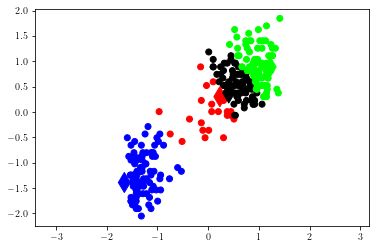

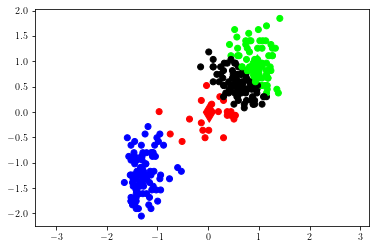

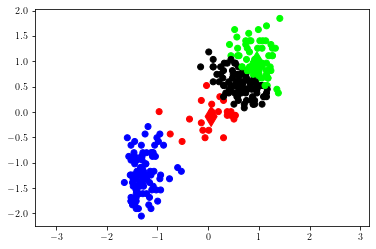

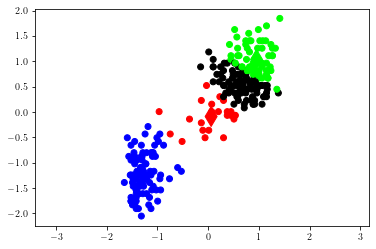

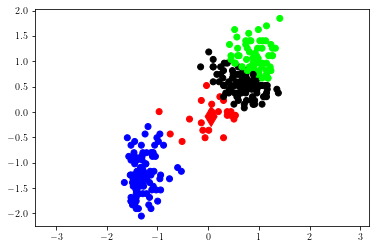

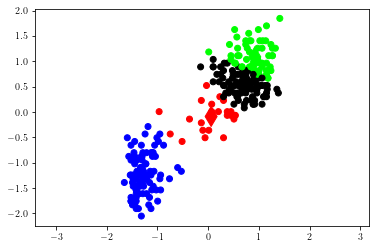

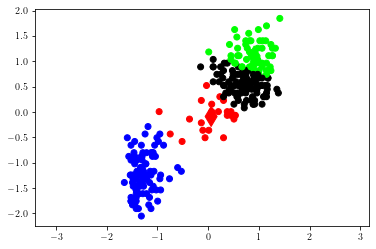

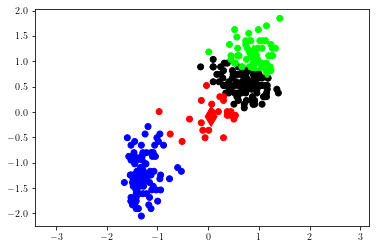

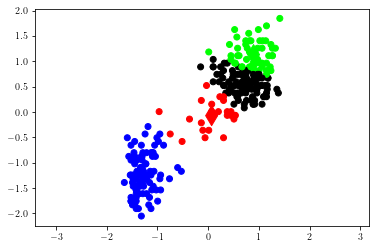

8


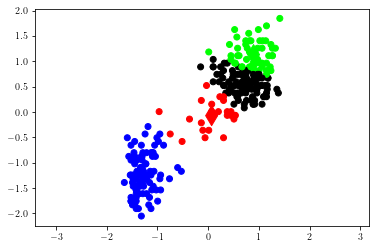

In [25]:
runKMeans(4, 'scaledfaithful.txt')